## Group 8 Assignment

In [1]:
#Importing Required Libraries
import numpy as np 
import pandas as pd
#from pandas_datareader import data
from sklearn import linear_model
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=(20, 10)
from tqdm.notebook import tqdm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV

In [2]:
#Importing Existing Data
flows = pd.read_excel("Flows_Clean.xlsx")
returns = pd.read_excel("Returns_Clean.xlsx")
tickers = pd.read_excel("PERMNO_Tickers.xlsx")
permno = returns.columns.tolist()[1:]

In [3]:
#Combining Flows & Returns Data by PERMNO & Date

flows_done = pd.DataFrame(columns=["Dates", "PERMNO", "Flow"])
returns_done = pd.DataFrame(columns=["Dates", "PERMNO", "Return"])


for i in permno:
    flows_1 = pd.DataFrame(columns=["Dates", "PERMNO", "Flow"])
    flows_1["Dates"]=flows["Dates"]
    flows_1["PERMNO"]=i
    flows_1["Flow"]=flows[i]
    flows_done=pd.concat([flows_done, flows_1])

    returns_1 = pd.DataFrame(columns=["Dates", "PERMNO", "Return"])
    returns_1["Dates"]=returns["Dates"]
    returns_1["PERMNO"]=i
    returns_1["Return"]=returns[i]
    returns_done=pd.concat([returns_done, returns_1])

merged_data=pd.merge(returns_done, flows_done, on=["Dates", "PERMNO"])


In [4]:
merged_data

,Dates,PERMNO,Return,Flow
0,19930401,55976,-0.019685,-4.696503
1,19930402,55976,-0.020080,-6.975709
2,19930405,55976,-0.024590,-5.642141
3,19930406,55976,-0.067227,-6.975709
4,19930407,55976,0.000000,-6.975709
...,...,...,...,...
195795,20001222,48725,0.026415,5.934239
195796,20001226,48725,0.003676,-1.281796
195797,20001227,48725,0.028083,3.428868
195798,20001228,48725,-0.040380,-11.641011


In [5]:
#Getting Laggs of Returns & Flows
no_of_lags = 3
merged_data_copy = merged_data.copy()

for lag in range(1, no_of_lags + 1):
    #Lagging Returns
    merged_data_copy["Return_" + str(lag)] = merged_data.groupby(["PERMNO"])["Return"].shift(lag)
    #Lagging Flows
    merged_data["Flow_" + str(lag)] = merged_data.groupby(["PERMNO"])["Flow"].shift(lag)

#Dropping NA's
merged_data_copy.dropna(subset = ["Return_1", "Return_2", "Return_3"], inplace = True)
merged_data.dropna(subset = ["Flow_1", "Flow_2", "Flow_3"], inplace = True)

#Merging to Create New DataFrame
final_data = pd.merge(merged_data_copy, merged_data, on=["Dates", "PERMNO", "Return", "Flow"])
final_data.head(10)

,Dates,PERMNO,Return,Flow,Return_1,Return_2,Return_3,Flow_1,Flow_2,Flow_3
0,19930406,55976,-0.067227,-6.975709,-0.024590,-0.020080,-0.019685,-5.642141,-6.975709,-4.696503
1,19930407,55976,0.000000,-6.975709,-0.067227,-0.024590,-0.020080,-6.975709,-5.642141,-6.975709
2,19930408,55976,0.040541,-6.975709,0.000000,-0.067227,-0.024590,-6.975709,-6.975709,-5.642141
3,19930412,55976,0.038961,-3.351631,0.040541,0.000000,-0.067227,-6.975709,-6.975709,-6.975709
4,19930413,55976,-0.033333,-2.878666,0.038961,0.040541,0.000000,-3.351631,-6.975709,-6.975709
5,19930414,55976,-0.060345,-6.975709,-0.033333,0.038961,0.040541,-2.878666,-3.351631,-6.975709
6,19930415,55976,0.013761,-6.975709,-0.060345,-0.033333,0.038961,-6.975709,-2.878666,-3.351631
7,19930416,55976,-0.036199,-5.351909,0.013761,-0.060345,-0.033333,-6.975709,-6.975709,-2.878666
8,19930419,55976,0.004695,-2.729153,-0.036199,0.013761,-0.060345,-5.351909,-6.975709,-6.975709
9,19930420,55976,-0.014019,-4.112889,0.004695,-0.036199,0.013761,-2.729153,-5.351909,-6.975709


In [6]:
#Splitting Data by PERMNO (i.e By Stock)
indv_stocks_data = {} #Dictionary Containing Data {permo:data}
for p in permno:
    data = final_data.loc[final_data["PERMNO"] == p]
    indv_stocks_data[p] = data.dropna()
print(indv_stocks_data[55976])

         Dates PERMNO    Return      Flow  Return_1  Return_2  Return_3  \
0     19930406  55976 -0.067227 -6.975709 -0.024590 -0.020080 -0.019685   
1     19930407  55976  0.000000 -6.975709 -0.067227 -0.024590 -0.020080   
2     19930408  55976  0.040541 -6.975709  0.000000 -0.067227 -0.024590   
3     19930412  55976  0.038961 -3.351631  0.040541  0.000000 -0.067227   
4     19930413  55976 -0.033333 -2.878666  0.038961  0.040541  0.000000   
...        ...    ...       ...       ...       ...       ...       ...   
1950  20001222  55976  0.014493  3.519515  0.057471  0.020781 -0.050680   
1951  20001226  55976 -0.035714  0.278894  0.014493  0.057471  0.020781   
1952  20001227  55976  0.038272  3.668618 -0.035714  0.014493  0.057471   
1953  20001228  55976  0.007134  0.794352  0.038272 -0.035714  0.014493   
1954  20001229  55976  0.003542  0.654678  0.007134  0.038272 -0.035714   

        Flow_1    Flow_2    Flow_3  
0    -5.642141 -6.975709 -4.696503  
1    -6.975709 -5.642141 

## OLS Regression - Out-of-Sample R^2 and RMSE for all 100 stocks

In [7]:
# Creating function to run Rolling-window OLS regressions
import statistics
def Rolling_Window_OLS(size, x_train, y_train):
    time = size
    y_preds_ols = []
    y_trues = []
    errors_ols = []
    y_preds_hm = []
    errors_hm = []
    for i in range(len(x_train)-size-1):
        ols_model = sm.OLS(y_train[time-size:time], x_train[time-size:time]).fit()
        y_predict_hm = y_train[time-size:time].mean()
        
        time += 1
        
        y_predict_ols = ols_model.predict(x_train[time])[0]
        
        y_true = y_train[time]
        error_ols = (y_true - y_predict_ols)**2
        error_hm = (y_true - y_predict_hm)**2
        
        y_preds_ols.append(y_predict_ols)
        y_preds_hm.append(y_predict_hm)
        y_trues.append(y_true)
        errors_ols.append(error_ols)
        errors_hm.append(error_hm)
        
        MSE_ols = statistics.mean(errors_ols)
        MSE_hm = statistics.mean(errors_hm)
        RMSE = (MSE_hm**0.5) - (MSE_ols**0.5)
        
    results = pd.DataFrame({"True Return":y_trues, "OLS Prediction":y_preds_ols, 
                            "Historical Mean Return":y_preds_hm, "Forecast Error (OLS)":errors_ols, 
                            "Forecast Error (Historical Mean)":errors_hm})
    return RMSE

In [8]:
RMSE_ols = []

for i in tqdm(permno):
    x=indv_stocks_data[i].loc[:,'Return_1':'Flow_3'].values
    y=indv_stocks_data[i].loc[:,'Return'].values
    x = sm.add_constant(x)
    RMSE_ols.append(Rolling_Window_OLS(200, x, y))

RMSE_ols

[-0.00048484137046778467,
 -0.0003944108636050325,
 -0.00038155520922434835,
 -0.00025667443086522385,
 4.3431923676305606e-05,
 -0.0005064528940290566,
 -0.0002722421982381557,
 -0.0013699875481813055,
 -0.0002176093471390715,
 -0.000786766150886832,
 -0.0002560084426872257,
 -0.0003731807331352789,
 -0.0010525999693412127,
 -0.00014415797881240158,
 -0.0006966926434901904,
 0.017188761766239444,
 -0.00018476074497315517,
 -0.00024528234292997553,
 -0.0005272926296287783,
 -0.0003444225848848251,
 -0.00023506952558631847,
 -0.00035596119626674083,
 -0.0004426812535045267,
 -0.0004199065459388439,
 -0.0002747352579494551,
 -0.00036661207924847117,
 -0.0005838208780953938,
 -0.00026170334846413804,
 -0.0003589194862837,
 -0.00012481283829451906,
 -0.00019150230182273312,
 -0.0009212485909216445,
 -0.00028020682249319667,
 -0.0005859228109644163,
 -0.00018868934261302012,
 -6.841274080734983e-05,
 -0.00024510920674430253,
 -0.0008874616252282849,
 -0.00016020128151258278,
 -0.00027014747

In [9]:
statistics.fmean(RMSE_ols)

-0.00020790004761595177

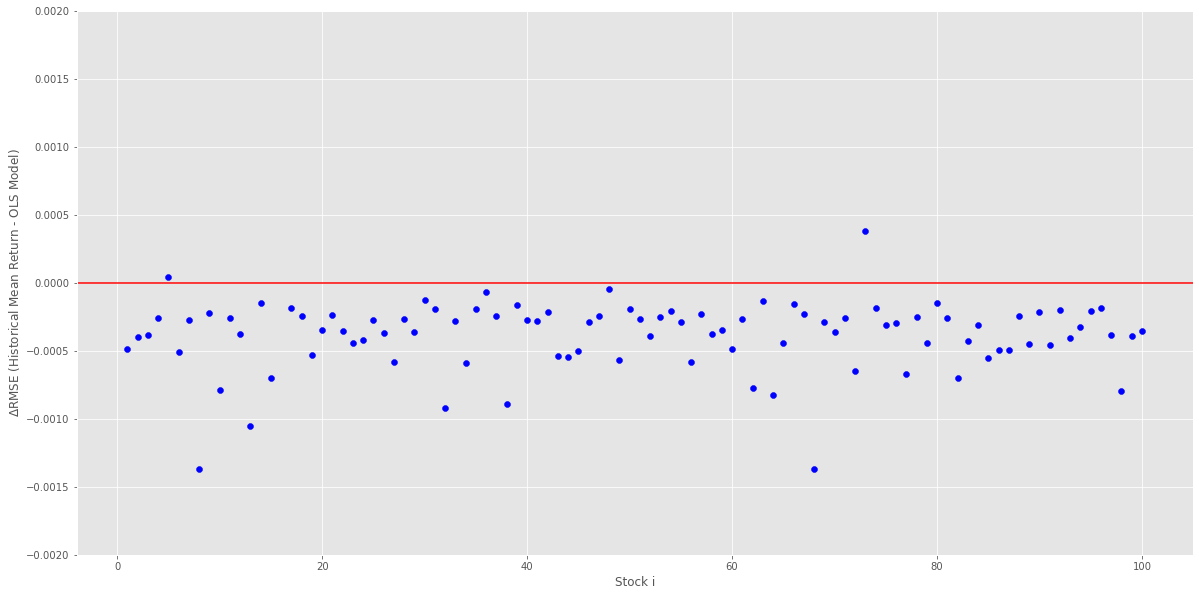

In [10]:
plt.style.use('ggplot')
plt.scatter(range(1,len(permno)+1), RMSE_ols, color='b')
plt.ylim(-0.002, 0.002)
plt.ylabel(r'$\Delta$'+"RMSE (Historical Mean Return - OLS Model)")
plt.xlabel("Stock i")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

## LASSO Model

### LASSO with single-lagged cross stock returns and flows

In [11]:
### Extend predictor variables to include a stock's cross-stock returns and net flows (1 lag)
X_full = {}
for i in tqdm(permno):
    permno_copy = permno.copy()
    permno_copy.remove(i)
    data = indv_stocks_data[i].drop("PERMNO", axis=1)
    for j in permno_copy:
        data = data.merge(indv_stocks_data[j][["Dates", "Return_1", "Flow_1"]], on='Dates')
    X_full[i] = data.dropna()

In [12]:
# Creating function to run Rolling-window LASSO regressions
import statistics
def Rolling_Window_LASSO(size, x, y, alphas):
    time = size
    y_preds_lasso = []
    y_trues = []
    errors_lasso = []
    y_preds_hm = []
    errors_hm = []
    for i in tqdm(range(len(x)-size-1)):
        lasso_model = LassoCV(cv=5, alphas=alphas, max_iter=10000, n_jobs=-1)
        lasso_model.fit(x[time-size:time], y[time-size:time])
        y_predict_hm = y[time-size:time].mean()

        time += 1
        y_predict_lasso = lasso_model.predict(x[time].reshape(1, -1))[0]
        
        y_true = y[time]
        error_lasso = (y_true - y_predict_lasso)**2
        error_hm = (y_true - y_predict_hm)**2

        y_preds_lasso.append(y_predict_lasso)
        y_preds_hm.append(y_predict_hm)
        y_trues.append(y_true)
        errors_lasso.append(error_lasso)
        errors_hm.append(error_hm)

    MSE_lasso = statistics.mean(errors_lasso)
    MSE_hm = statistics.mean(errors_hm)
    RMSE = (MSE_hm**0.5) - (MSE_lasso**0.5)

    results = pd.DataFrame({"True Return":y_trues, "Lasso Prediction":y_preds_lasso, 
                             "Historical Mean Return":y_preds_hm, "Forecast Error (LASSO)":errors_lasso, 
                             "Forecast Error (Historical Mean)":errors_hm})
    return RMSE

In [157]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
window_size = 200
RMSE_lasso1 = []

for p in tqdm(permno):
        x = X_full[p].iloc[:,3:].values
        y = X_full[p].iloc[:,1].values
        RMSE_lasso1.append(Rolling_Window_LASSO(window_size, x, y, alphas))

In [523]:
statistics.fmean(RMSE_lasso1)

-3.9809434162181024e-05

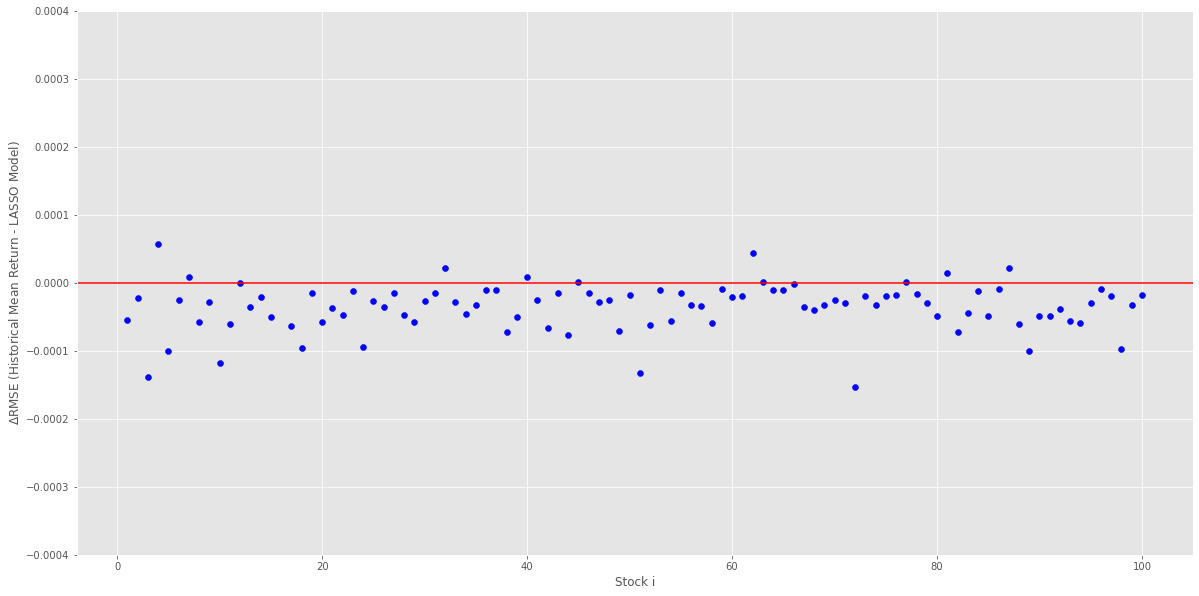

In [486]:
plt.style.use('ggplot')
plt.scatter(range(1,len(permno)+1), RMSE_lasso1, color='b')
plt.ylim(-0.0004, 0.0004)
plt.ylabel(r'$\Delta$'+"RMSE (Historical Mean Return - LASSO Model)")
plt.xlabel("Stock i")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

### LASSO with Kitchen-sink Model

In [13]:
### Extend predictor variables to include a stock's cross-stock returns and net flows (3 lags)
X_kitchen_sink = {}
for i in tqdm(permno):
    permno_copy = permno.copy()
    permno_copy.remove(i)
    data = indv_stocks_data[i].drop("PERMNO", axis=1)
    for j in permno_copy:
        data = data.merge(indv_stocks_data[j][["Dates", "Return_1", "Flow_1", 
                                               "Return_2", "Flow_2", "Return_3", "Flow_3" ]], on='Dates')
    X_kitchen_sink[i] = data.dropna()

In [462]:
# Running the LASSO (L=3) on 30% of the data
alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
window_size = 200
RMSE_lasso2 = []

for p in tqdm(permno):
        x = X_kitchen_sink[p].iloc[:,3:].values
        y = X_kitchen_sink[p].iloc[:,1].values
        # We use train-test not to divide data into training and test data but rather to use a 30% subset of data
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
        RMSE_lasso2.append(Rolling_Window_LASSO(window_size, x_test, y_test, alphas))
    


[-2.5610181559235223e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05]


/Users/Parth/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038298530479617633, tolerance: 0.0003009848934776994
  model = cd_fast.enet_coordinate_descent(



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07]



[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026


[-2.5610181559235223e-05, -4.216004647124294e-05, 1.3147421279446903e-06, -1.2870753256132711e-05, -0.0001432573702578599, -8.546307235145212e-06, -1.99365810698085e-06, -6.867076713556325e-06, -7.443156437945617e-05, -0.0002718303094229116, -6.337375163077003e-05, 2.7857924773735943e-05, -1.9781778996176558e-05, -6.078769650674429e-05, -7.55790618672536e-05, 7.105820026914733e-06, -0.0002012851094688184, -1.6050626748864705e-05, -1.0135805805090714e-05, -2.323041552738589e-05, 4.655410395514037e-05, -0.00014823886546039625, -0.00016760708129714627, -2.985529071447557e-05, 6.524997474798011e-06, 8.135745655752508e-05, -3.363903297339682e-05, -8.965230651473283e-06, -2.2837712461983017e-05, -7.118266544007407e-05, -1.766061867764998e-05, -0.00012170127213687737, 1.5047122443323513e-06, -0.0001227158183230298, -0.00011940949193265694, -3.916962292892928e-05, 3.539693097080049e-06, -8.763751643753315e-05, -3.684727537296706e-05, -4.41268459439384e-06, 2.4400292485821096e-07, -2.211063026

In [522]:
statistics.fmean(RMSE_lasso2)

-4.2817896829722736e-05

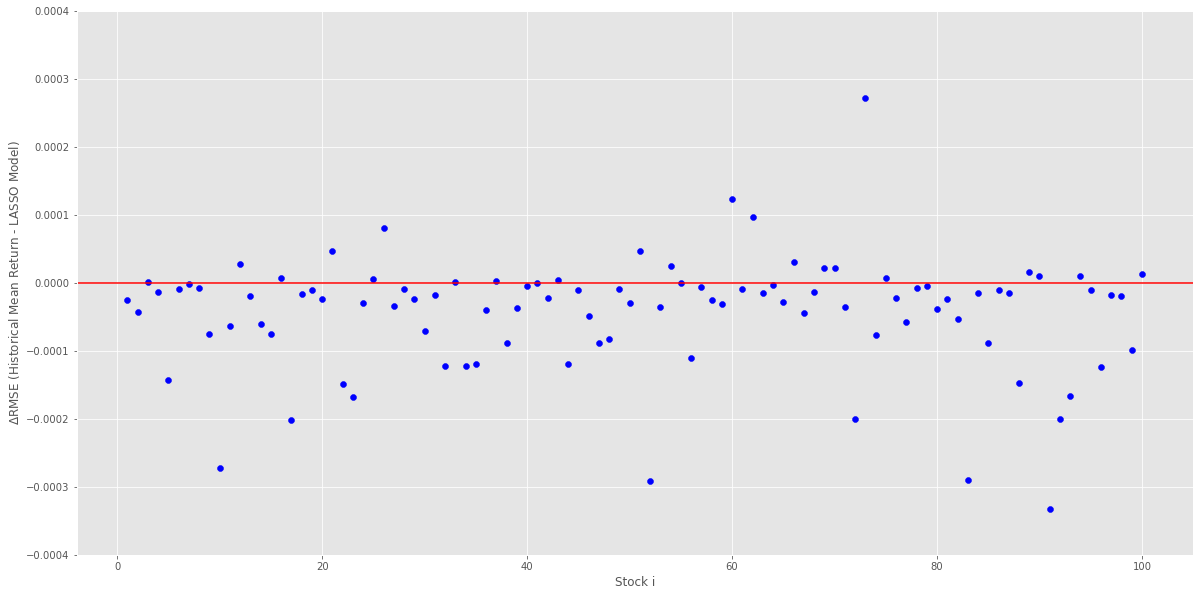

In [473]:
plt.style.use('ggplot')
plt.scatter(range(1,len(permno)+1), RMSE_lasso2, color='b')
plt.ylim(-0.0004, 0.0004)
plt.ylabel(r'$\Delta$'+"RMSE (Historical Mean Return - LASSO Model)")
plt.xlabel("Stock i")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

### Random Forest (L=3)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


In [15]:
# Creating function to run Rolling-window Random Forest regressions
def Rolling_Window_RF(size, x, y, param_grid):
    time = size
    errors_rf = []
    errors_hm = []
    y_preds_hm = []
    y_preds_rf = []
    
    RF = RandomForestRegressor(n_jobs=-1)
    grid_cv = GridSearchCV(estimator=RF, cv=5, param_grid=param_grid, n_jobs = -1)    

    for i in tqdm(range(len(x)-size-1)):
        grid_cv.fit(x[time-size:time], y[time-size:time])
        y_predict_hm = y[time-size:time].mean()
        y_preds_hm.append(y_predict_hm)

        time += 1
        y_predict_rf = grid_cv.predict(x[time].reshape(1, -1))[0]
        y_preds_rf.append(y_predict_rf)
        
        y_true = y[time]
        error_rf = (y_true - y_predict_rf)**2
        error_hm = (y_true - y_predict_hm)**2

        errors_rf.append(error_rf)
        errors_hm.append(error_hm)

    MSE_rf = statistics.mean(errors_rf)
    MSE_hm = statistics.mean(errors_hm)
    RMSE = (MSE_hm**0.5) - (MSE_rf**0.5)

    results = pd.DataFrame({"RF Prediction":y_preds_rf, "Historical Mean Return":y_preds_hm,})
    return RMSE

In [190]:
# Running the Random Forest Model on 30% of the data
RMSE_RF = []
param_grid = {'min_samples_leaf':[10,25,50]}
for p in tqdm(permno[:10]):
        x = X_kitchen_sink[p].iloc[:,3:].values
        y = X_kitchen_sink[p].iloc[:,1].values
        # We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
        RMSE_RF.append(Rolling_Window_RF(size, x_test, y_test, param_grid))


In [521]:
statistics.fmean(RMSE_RF)


8.619281313194306e-05

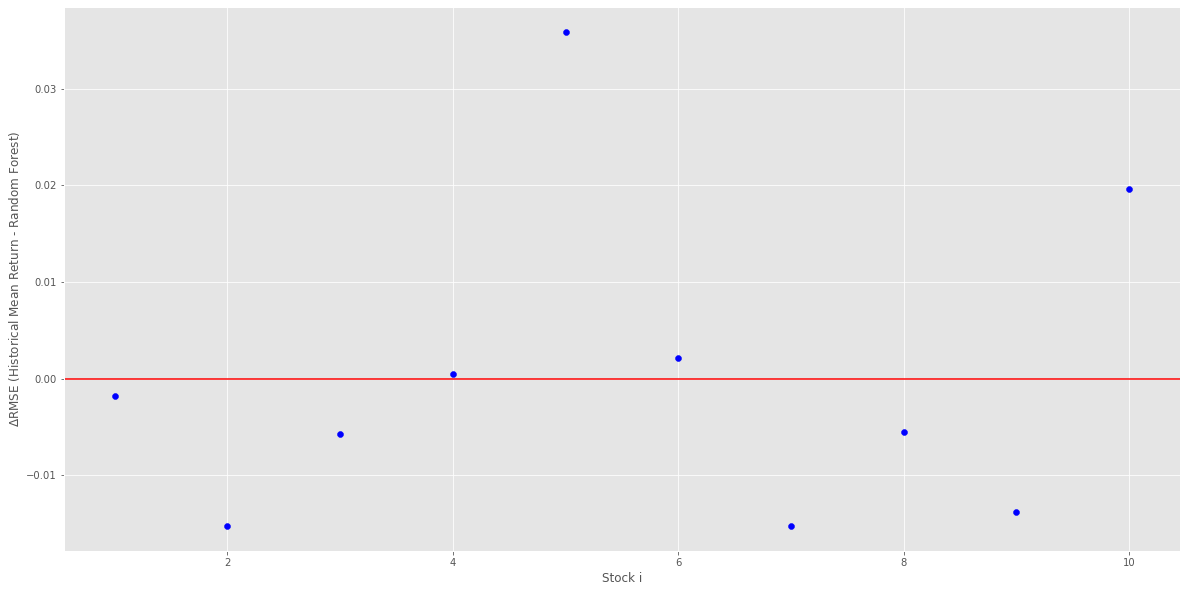

In [494]:
plt.style.use('ggplot')
plt.scatter(range(1, len(permno[:10]) + 1), RMSE_RF, color='b')
plt.ylabel(r'$\Delta$'+"RMSE (Historical Mean Return - Random Forest)")
plt.xlabel("Stock i")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

## Classification

In [16]:
###Building Classifiers
bins=[0]
#Data Wrangling
data_clf = {}
for p in tqdm(permno):
    data_clf[p] = X_kitchen_sink[p].copy()
    for col in data_clf[p].columns[1:]:
        data_clf[p][col] = np.digitize(data_clf[p][col], bins=bins) 

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# Creating function to run Rolling-window Lasso Classification
def Rolling_Window_Lasso_clf(size, x, y, param_grid):
    time = size
    
    errors_clf = []
    errors_hm = []
    
    clf = LogisticRegression(solver = 'saga', penalty='l1', n_jobs=-1)
    grid_cv = GridSearchCV(estimator=clf, cv=5, param_grid=param_grid, n_jobs = -1)    

    for i in tqdm(range(len(x)-size-1)):
        grid_cv.fit(x[time-size:time], y[time-size:time])
        if y[time-size:time].mean() < 0.5:
            y_predict_hm = 0
        else: 
            y_predict_hm = 1

        time += 1
        
        y_predict_clf = grid_cv.predict(x[time].reshape(1, -1))[0]
        
        y_true = y[time]
        error_clf = (y_true - y_predict_clf)**2
        error_hm = (y_true - y_predict_hm)**2

        errors_clf.append(error_clf)
        errors_hm.append(error_hm)

    score_clf = 1 - statistics.fmean(errors_clf)
    score_hm = 1 - statistics.fmean(errors_hm)
    score_diff = score_clf - score_hm

    return score_diff

In [20]:
alphas = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
size = 200
cs = alphas
grid={"C":cs}

In [411]:
# Running the Lasso Classification model on 30% of the data for 10 randomly picked stocks
SCORE_LASSO_CLF = []
for p in tqdm(permno[:10]):
    x = data_clf[p].iloc[:,3:].values
    y = data_clf[p].iloc[:,1].values
    # We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
    SCORE_LASSO_CLF.append(Rolling_Window_Lasso_clf(size, x_test, y_test, grid))

In [525]:
SCORE_LASSO_CLF

[0.020725388601036232,
 -0.03886010362694303,
 -0.010362694300518172,
 -0.015544041450777146,
 0.0,
 -0.023316062176165775,
 -0.007772020725388518,
 0.005181347150259086,
 -0.002590673575129543,
 0.0]

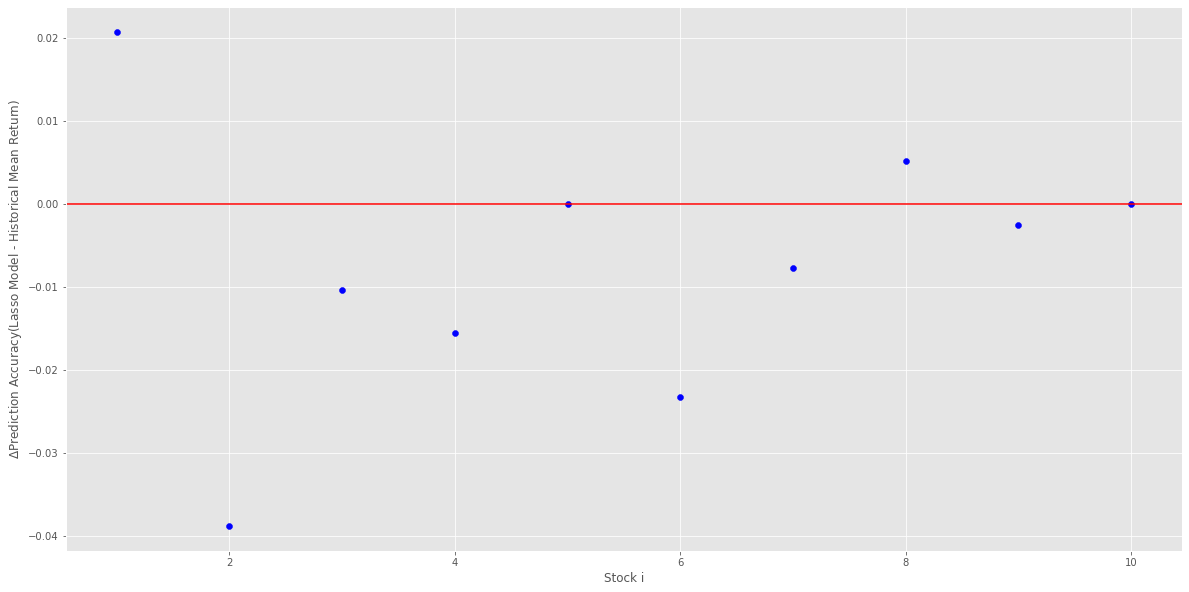

In [527]:
plt.style.use('ggplot')
plt.scatter(range(1, len(permno[:10]) + 1), SCORE_LASSO_CLF, color='b')
plt.ylabel(r'$\Delta$'+"Prediction Accuracy(Lasso Model - Historical Mean Return)")
plt.xlabel("Stock i")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

## Random Forest Classification

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# To tune the Hyperparameter - minimum sample leaf
param_grid = {'min_samples_leaf':[10,25,50]}

In [24]:
# Creating function to run Rolling-window Random Forest Classification
def Rolling_Window_RF_clf(size, x, y, param_grid):
    time = size
    errors_rf_clf = []
    errors_hm = []
    RF_clf = RandomForestClassifier()
    grid_cv = GridSearchCV(estimator=RF_clf, cv=5, param_grid=param_grid)    

    for i in tqdm(range(len(x)-size-1)):
        grid_cv.fit(x[time-size:time], y[time-size:time])
        if y[time-size:time].mean() < 0.5:
            y_predict_hm = 0
        else: 
            y_predict_hm = 1

        time += 1
        y_predict_rf_clf = grid_cv.predict(x[time].reshape(1, -1))[0]
        
        y_true = y[time]
        error_rf_clf = (y_true - y_predict_rf_clf)**2
        error_hm = (y_true - y_predict_hm)**2

        errors_rf_clf.append(error_rf_clf)
        errors_hm.append(error_hm)
        

    score_rf_clf = 1 - statistics.fmean(errors_rf_clf)
    score_hm = 1 - statistics.fmean(errors_hm)
    score_diff = score_rf_clf - score_hm

    return score_diff

In [40]:
# Running the Random Forest Classification model on 30% of the data for 10 randomly picked stocks
SCORE_RF_CLF = []
for p in tqdm(permno[:10]):
    x = data_clf[p].iloc[:,3:].values
    y = data_clf[p].iloc[:,1].values
    # We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False) 
    SCORE_RF_CLF.append(Rolling_Window_RF_clf(size, x_test, y_test, param_grid))

In [ ]:
#SCORE_RF_CLF

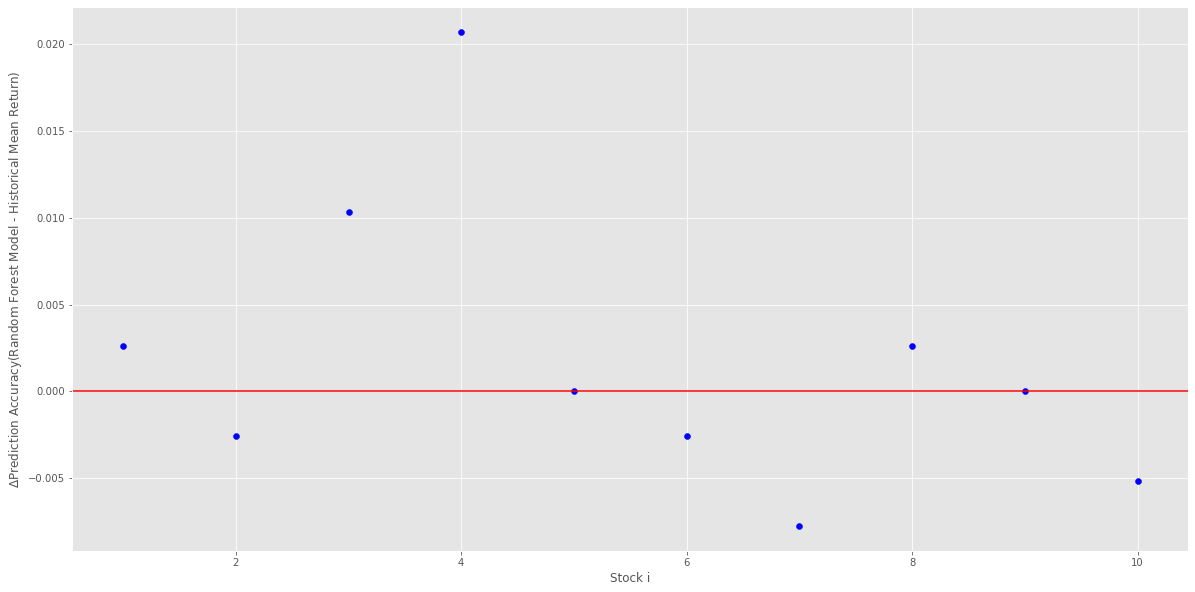

In [41]:
plt.style.use('ggplot')
plt.scatter(range(1, len(permno[:10]) + 1), SCORE_RF_CLF, color='b')
plt.ylabel(r'$\Delta$'+"Prediction Accuracy(Random Forest Model - Historical Mean Return)")
plt.xlabel("Stock i")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

### Graph Cumulative Returns of Randomly picked DTE ENERGY CO

In [25]:
# Creating function to run Rolling-window OLS regressions
def Rolling_Window_OLS(size, x_train, y_train):
    time = size
    y_preds_ols = []
    y_trues = []
    errors_ols = []
    y_preds_hm = []
    errors_hm = []
    for i in range(len(x_train)-size-1):
        ols_model = sm.OLS(y_train[time-size:time], x_train[time-size:time]).fit()
        y_predict_hm = y_train[time-size:time].mean()
        
        time += 1
        
        y_predict_ols = ols_model.predict(x_train[time])[0]
        
        y_true = y_train[time]
        error_ols = (y_true - y_predict_ols)**2
        error_hm = (y_true - y_predict_hm)**2
        
        y_preds_ols.append(y_predict_ols)
        y_preds_hm.append(y_predict_hm)
        y_trues.append(y_true)
        errors_ols.append(error_ols)
        errors_hm.append(error_hm)
        
        MSE_ols = statistics.mean(errors_ols)
        MSE_hm = statistics.mean(errors_hm)
        RMSE = (MSE_hm**0.5) - (MSE_ols**0.5)
        
    results = pd.DataFrame({"True Return":y_trues, "OLS Prediction":y_preds_ols, 
                            "Historical Mean Return":y_preds_hm, "Forecast Error (OLS)":errors_ols, 
                            "Forecast Error (Historical Mean)":errors_hm})
    return RMSE, results

In [26]:
# Running OLS model for DTE Energy on 30% of the data
x=indv_stocks_data[11674].loc[:,'Return_1':'Flow_3'].values
y=indv_stocks_data[11674].loc[:,'Return'].values
x = sm.add_constant(x)
# We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)

RMSE_11674_ols, result_ols = Rolling_Window_OLS(200, x_test, y_test)


In [27]:
result_ols

,True Return,OLS Prediction,Historical Mean Return,Forecast Error (OLS),Forecast Error (Historical Mean)
0,-0.002933,-0.000575,0.000471,0.000006,0.000012
1,-0.013235,0.003042,0.000449,0.000265,0.000187
2,-0.004471,0.000592,0.000404,0.000026,0.000024
3,0.001497,-0.000059,0.000271,0.000002,0.000002
4,-0.002990,0.001362,0.000278,0.000019,0.000011
...,...,...,...,...,...
381,0.018212,-0.000039,0.001607,0.000333,0.000276
382,0.019512,0.003209,0.001540,0.000266,0.000323
383,-0.006380,0.001396,0.001548,0.000060,0.000063
384,0.000000,0.003029,0.001677,0.000009,0.000003


In [28]:
# Creating function to run Rolling-window LASSO regressions
import statistics
def Rolling_Window_LASSO(size, x, y, alphas):
    time = size
    y_preds_lasso = []
    y_trues = []
    errors_lasso = []
    y_preds_hm = []
    errors_hm = []
    for i in tqdm(range(len(x)-size-1)):
        lasso_model = LassoCV(cv=5, alphas=alphas, max_iter=10000, n_jobs=-1)
        lasso_model.fit(x[time-size:time], y[time-size:time])
        y_predict_hm = y[time-size:time].mean()

        time += 1
        y_predict_lasso = lasso_model.predict(x[time].reshape(1, -1))[0]
        
        y_true = y[time]
        error_lasso = (y_true - y_predict_lasso)**2
        error_hm = (y_true - y_predict_hm)**2

        y_preds_lasso.append(y_predict_lasso)
        y_preds_hm.append(y_predict_hm)
        y_trues.append(y_true)
        errors_lasso.append(error_lasso)
        errors_hm.append(error_hm)

    MSE_lasso = statistics.mean(errors_lasso)
    MSE_hm = statistics.mean(errors_hm)
    RMSE = (MSE_hm**0.5) - (MSE_lasso**0.5)

    results = pd.DataFrame({"True Return":y_trues, "Lasso Prediction":y_preds_lasso, 
                             "Historical Mean Return":y_preds_hm, "Forecast Error (LASSO)":errors_lasso, 
                             "Forecast Error (Historical Mean)":errors_hm})
    return RMSE, results

In [29]:
# Running LASSO (L=1) model for DTE Energy on 30% of the data
x = X_full[11674].iloc[:,3:].values
y = X_full[11674].iloc[:,1].values
# We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
RMSE_11674_lasso1, results_lasso1 = Rolling_Window_LASSO(200, x_test, y_test, alphas)

In [30]:
results_lasso1

,True Return,Lasso Prediction,Historical Mean Return,Forecast Error (LASSO),Forecast Error (Historical Mean)
0,-0.002933,0.000471,0.000471,0.000012,0.000012
1,-0.013235,0.000449,0.000449,0.000187,0.000187
2,-0.004471,0.000404,0.000404,0.000024,0.000024
3,0.001497,0.000271,0.000271,0.000002,0.000002
4,-0.002990,0.000278,0.000278,0.000011,0.000011
...,...,...,...,...,...
381,0.018212,0.001607,0.001607,0.000276,0.000276
382,0.019512,0.001540,0.001540,0.000323,0.000323
383,-0.006380,0.001548,0.001548,0.000063,0.000063
384,0.000000,0.001677,0.001677,0.000003,0.000003


In [31]:
# Running LASSO (L=3) model for DTE Energy on 30% of the data
x = X_kitchen_sink[11674].iloc[:,3:].values
y = X_kitchen_sink[11674].iloc[:,1].values
# We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
RMSE_11674_lasso2, results_lasso2 = Rolling_Window_LASSO(200, x_test, y_test, alphas)

In [32]:
results_lasso2

,True Return,Lasso Prediction,Historical Mean Return,Forecast Error (LASSO),Forecast Error (Historical Mean)
0,-0.002933,0.000471,0.000471,0.000012,0.000012
1,-0.013235,0.000449,0.000449,0.000187,0.000187
2,-0.004471,0.000404,0.000404,0.000024,0.000024
3,0.001497,0.000271,0.000271,0.000002,0.000002
4,-0.002990,0.000278,0.000278,0.000011,0.000011
...,...,...,...,...,...
381,0.018212,0.001607,0.001607,0.000276,0.000276
382,0.019512,0.001540,0.001540,0.000323,0.000323
383,-0.006380,0.001548,0.001548,0.000063,0.000063
384,0.000000,0.001677,0.001677,0.000003,0.000003


In [33]:
# Creating function to run Rolling-window Random Forest regressions
def Rolling_Window_RF(size, x, y, param_grid):
    time = size
    errors_rf = []
    errors_hm = []
    y_preds_hm = []
    y_preds_rf = []
    
    RF = RandomForestRegressor(n_jobs=-1)
    grid_cv = GridSearchCV(estimator=RF, cv=5, param_grid=param_grid, n_jobs = -1)    

    for i in tqdm(range(len(x)-size-1)):
        grid_cv.fit(x[time-size:time], y[time-size:time])
        y_predict_hm = y[time-size:time].mean()
        y_preds_hm.append(y_predict_hm)

        time += 1
        y_predict_rf = grid_cv.predict(x[time].reshape(1, -1))[0]
        y_preds_rf.append(y_predict_rf)
        
        y_true = y[time]
        error_rf = (y_true - y_predict_rf)**2
        error_hm = (y_true - y_predict_hm)**2

        errors_rf.append(error_rf)
        errors_hm.append(error_hm)

    MSE_rf = statistics.mean(errors_rf)
    MSE_hm = statistics.mean(errors_hm)
    RMSE = (MSE_hm**0.5) - (MSE_rf**0.5)

    results = pd.DataFrame({"RF Prediction":y_preds_rf, "Historical Mean Return":y_preds_hm,})
    return RMSE, results

In [34]:
# Running Random Forest model for DTE Energy on 30% of the data
x = X_kitchen_sink[11674].iloc[:,3:].values
y = X_kitchen_sink[11674].iloc[:,1].values
# We use train-test not to divide data into training and test data but rather to use a 30% subset of data to save computing time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
RMSE_11674_rf, results_rf = Rolling_Window_RF(200, x_test, y_test, param_grid)

In [35]:
results_rf

,RF Prediction,Historical Mean Return
0,-0.002925,0.000471
1,0.002090,0.000449
2,0.000756,0.000404
3,0.001254,0.000271
4,0.000817,0.000278
...,...,...
381,0.000061,0.001607
382,0.002114,0.001540
383,0.001546,0.001548
384,0.000734,0.001677


In [36]:
predictions_df = pd.DataFrame({"OLS Prediction":result_ols["OLS Prediction"].cumsum().tolist(), 
                              "Historical Mean Return":result_ols["Historical Mean Return"].cumsum().tolist(),
                              "LASSO (L=1)":results_lasso1["Lasso Prediction"].cumsum().tolist(),
                              "LASSO (L=3)":results_lasso2["Lasso Prediction"].cumsum().tolist(),
                              "Random Forest":results_rf["RF Prediction"].cumsum().tolist()})

In [37]:
predictions_df["True Return"] = result_ols["True Return"].cumsum().tolist()

In [38]:
predictions_df

,OLS Prediction,Historical Mean Return,LASSO (L=1),LASSO (L=3),Random Forest,True Return
0,-0.000575,0.000471,0.000471,0.000471,-0.002925,-0.002933
1,0.002467,0.000920,0.000920,0.000920,-0.000835,-0.016168
2,0.003060,0.001324,0.001324,0.001324,-0.000080,-0.020639
3,0.003001,0.001595,0.001595,0.001595,0.001174,-0.019142
4,0.004363,0.001873,0.001873,0.001873,0.001991,-0.022132
...,...,...,...,...,...,...
381,-0.054530,-0.077955,-0.077955,-0.078724,-0.015889,0.043391
382,-0.051321,-0.076415,-0.076415,-0.077184,-0.013775,0.062903
383,-0.049926,-0.074867,-0.074867,-0.075635,-0.012229,0.056523
384,-0.046896,-0.073190,-0.073190,-0.073959,-0.011496,0.056523


<AxesSubplot:xlabel='Time Period', ylabel='Predicted Cumulative Returns'>

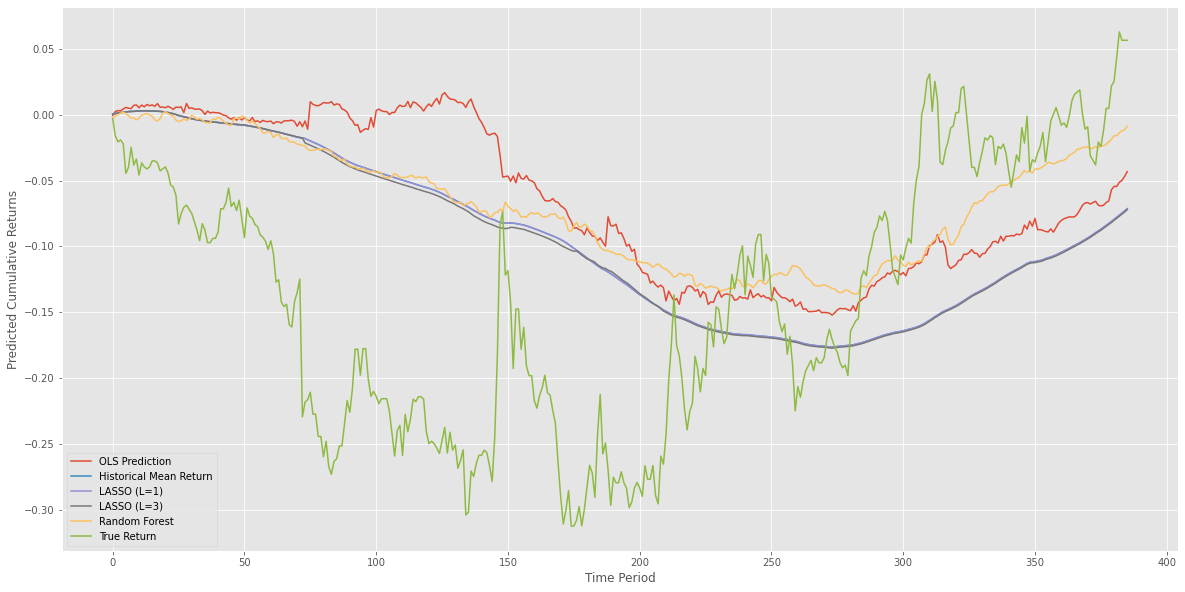

In [39]:
predictions_df.plot(xlabel="Time Period", ylabel="Predicted Cumulative Returns")